# Anomalie Detection Filling Station

Thi notebook is part of the Master's thesis "Anomalieerkennung in industriellen Produktionsprozessen mit
Transformer-Modellen". Further information for pre-processing, model and evaluation can be found in this Master's thesis. 

In [1]:
import sys 
sys.path.append('../')
import copy

import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
import sklearn
import seaborn as sns

import timeserieslibrary.Transformer_Model as tm
import timeserieslibrary.Preprocessing as pp
import timeserieslibrary.Learning_Rate_Schedule as lrs


print("is GPU:",tf.test.is_gpu_available())
print("is cuda:",tf.test.is_built_with_cuda())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
is GPU: True
is cuda: True
2.10.0


# Load the Data


In [2]:
#Trainings Data
data_normal_train1 = pd.read_csv("Daten/Normal/Normal.csv")
data_normal_train2 = pd.read_csv("Daten/Normal/Normal3.csv")
data_normal_train3 = pd.read_csv("Daten/Normal/Normal_Auslauf.csv")
data_normal_train4 = pd.read_csv("Daten/Normal/StartUp.csv")
data_normal_train5 = pd.read_csv("Daten/Normal/Normal_Wenig_Flaschen.csv")
#Combine all trainings data
data_normal_train = pd.concat((data_normal_train1, data_normal_train2, data_normal_train3, data_normal_train4, data_normal_train5))

#Normal Validation Data
data_normal_valid = pd.read_csv("Daten/Normal/Normal2.csv")

#Normal Test Data
data_test_normal = pd.read_csv("Daten/Normal/Normal4.csv")


#Anomalie Data
data_test_drehtisch_widerstand1=pd.read_csv("Daten/Anomalie/Rondel_Wiederstand.csv")
data_test_drehtisch_widerstand2=pd.read_csv("Daten/Anomalie/Rondel_Wiederstand2.csv")
data_test_drehtisch_widerstand = data_test_drehtisch_widerstand1 #pd.concat((data_test_drehtisch_widerstand1, data_test_drehtisch_widerstand2))
data_test_drehtisch_blockiert = pd.read_csv("Daten/Anomalie/Rondel_Blockiert.csv")
data_test_drehtisch_zu_wenig_widerstand = pd.read_csv("Daten/Anomalie/Rondel_zu_wenig_wiederstand.csv")
data_test_widerstand_transportband = pd.read_csv("Daten/Anomalie/Widerstand_Transport.csv")
data_test_widerstand_zufuerband = pd.read_csv("Daten/Anomalie/Wiederstand_Zuführ.csv")

#Cobine all test data
all_test_data = [data_test_normal, data_test_drehtisch_widerstand, data_test_drehtisch_blockiert, data_test_drehtisch_zu_wenig_widerstand, data_test_widerstand_transportband]
all_test_data_names=["Normal", "Drehtisch Widerstand",  "Drehtisch Blockiert", "Drehtisch zu wenig widerstand", "Transportband Widerstand"]

In [3]:
print("Trainings Data Shape:", data_normal_train.shape)
print("Validation Data Shape:", data_normal_valid.shape)

for variable, testdata in enumerate(all_test_data):
    print(all_test_data_names[variable], "Test Data Shape:", testdata.shape)

Trainings Data Shape: (404296, 22)
Validation Data Shape: (108519, 22)
Normal Test Data Shape: (71926, 22)
Drehtisch Widerstand Test Data Shape: (24231, 22)
Drehtisch Blockiert Test Data Shape: (11164, 22)
Drehtisch zu wenig widerstand Test Data Shape: (14416, 22)
Transportband Widerstand Test Data Shape: (12636, 22)


In [4]:
print(data_normal_train.shape)
print(data_normal_valid.shape)
print(data_test_normal.shape)

(404296, 22)
(108519, 22)
(71926, 22)


In [5]:
print(data_test_drehtisch_widerstand.shape)
print(data_test_drehtisch_blockiert.shape)
print(data_test_drehtisch_zu_wenig_widerstand.shape)
print(data_test_widerstand_transportband.shape)

(24231, 22)
(11164, 22)
(14416, 22)
(12636, 22)


In [6]:
input_variablen = range(1,17,1)#
bool_variablen= [3,4,5,6,7,8,9,10,11,17,18,19,20,21]
ground_truth_variable= [2,12,14]
name_list = list(data_normal_valid.columns.values.tolist())

name_dict = {} 
for variable in range(len(name_list)):
    name_dict[variable]=name_list[variable]

In [7]:
variablen_to_mask_index_list=[]
for variable in ground_truth_variable:
    variablen_to_mask_index_list += [np.where(np.array(input_variablen) == variable)]

In [8]:

ground_truth_name_list=[name_list[i] for i in ground_truth_variable]
ground_truth_variable_names = [name_dict[j] for j in ground_truth_variable]
print(ground_truth_variable_names)

['Gesamtstrom', 'Integerwert für den Motorstrom am Transportförderband', 'Integerwert für den Motorstrom am Drehtisch']


# Preprocess Data

In [9]:
input_window=64
sliding_window_step=1
downsampling_faktor=64
mask_input_data=True
scale_data=True
add_time_stamp=True
data_multiplicator_for_masking = 4
data_mask_lenght=0.5

In [10]:
#Window_lenght_in_ms
original_sample_time=6
window_time=original_sample_time*downsampling_faktor*input_window
print("window time", np.round(window_time/1000, 2))

window time 24.58


In [11]:
#ts_processing = pp.TimeSeriesPreprocessingPipeline(  JSON_config_file="preprocessing_config.json")
                                                 
ts_processing = pp.TimeSeriesPreprocessingPipeline(  split_time_series_into_window_of_len=input_window, 
                                             input_variable_index_list=input_variablen, 
                                             downsampling_faktor=downsampling_faktor,       
                                             index_list_bool_variablen=bool_variablen,                                       
                                             sliding_window_step=sliding_window_step, 
                                             add_time_stamp=add_time_stamp, 
                                             scale_data=scale_data,                                            
                                             ground_truth_variable_index_list=ground_truth_variable,
                                             mask_input_data=mask_input_data,
                                             data_mask_lenght=data_mask_lenght,
                                             data_multiplicator_for_masking=data_multiplicator_for_masking,
                                             )


x_train, y_train = ts_processing(data_normal_train, is_test_data=False)
x_valid, y_valid = ts_processing(data_normal_valid, is_test_data=True)

ts_processing.save_config_as_JSON()


Input data shape: (404296, 22)
Shape of x data (25020, 64, 17)
Shape of y data (25020, 64, 3)

Input data shape: (108519, 22)
Shape of x data (1633, 64, 17)
Shape of y data (1633, 64, 3)


for variable in range(x_train.shape[-1]-1):
    
    print("Variable:", name_list[input_variablen[variable]])
    plt.plot(x_train[1,:,variable])
    plt.show()

In [12]:
test_data_preprocessed_x = []
test_data_preprocessed_y= []
for variable in all_test_data:
    x_, y_= ts_processing(variable, stride_of_window = 1, is_test_data=True)
    test_data_preprocessed_x += [np.array(x_,dtype=np.float32)]
    test_data_preprocessed_y += [np.array(y_,dtype=np.float32)]



Input data shape: (71926, 22)
Shape of x data (1061, 64, 17)
Shape of y data (1061, 64, 3)

Input data shape: (24231, 22)
Shape of x data (316, 64, 17)
Shape of y data (316, 64, 3)

Input data shape: (11164, 22)
Shape of x data (112, 64, 17)
Shape of y data (112, 64, 3)

Input data shape: (14416, 22)
Shape of x data (163, 64, 17)
Shape of y data (163, 64, 3)

Input data shape: (12636, 22)
Shape of x data (135, 64, 17)
Shape of y data (135, 64, 3)


# Show preprocessed data 

Variable: Integerwert für den Motorstrom am Transportförderband


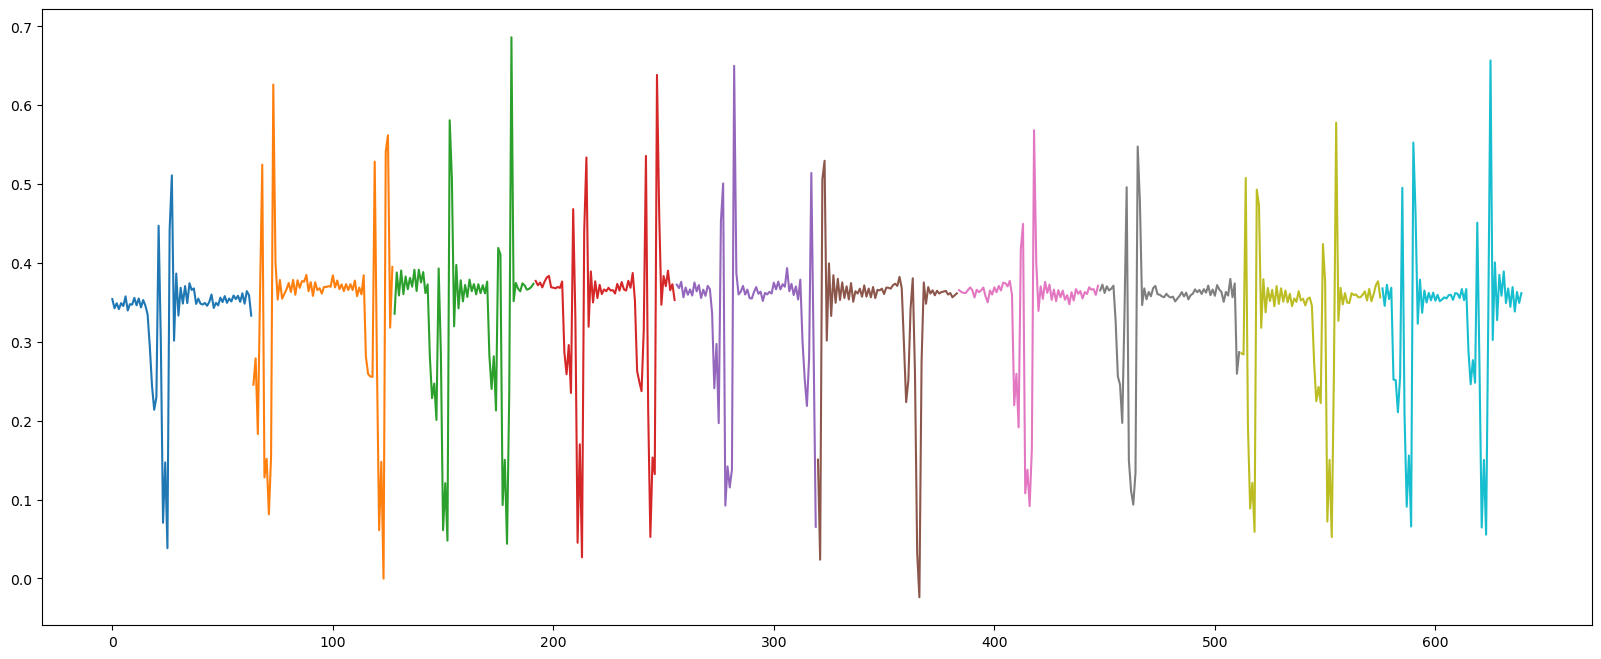

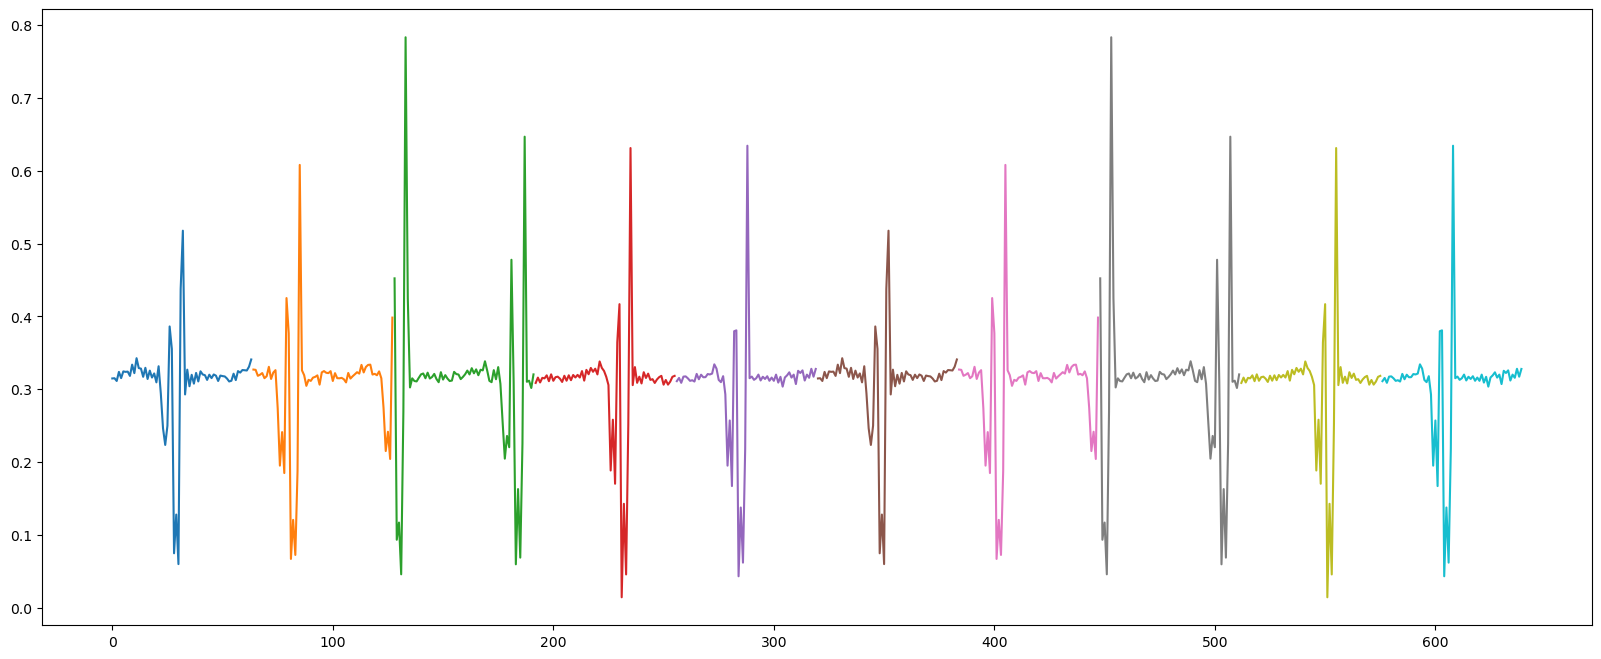

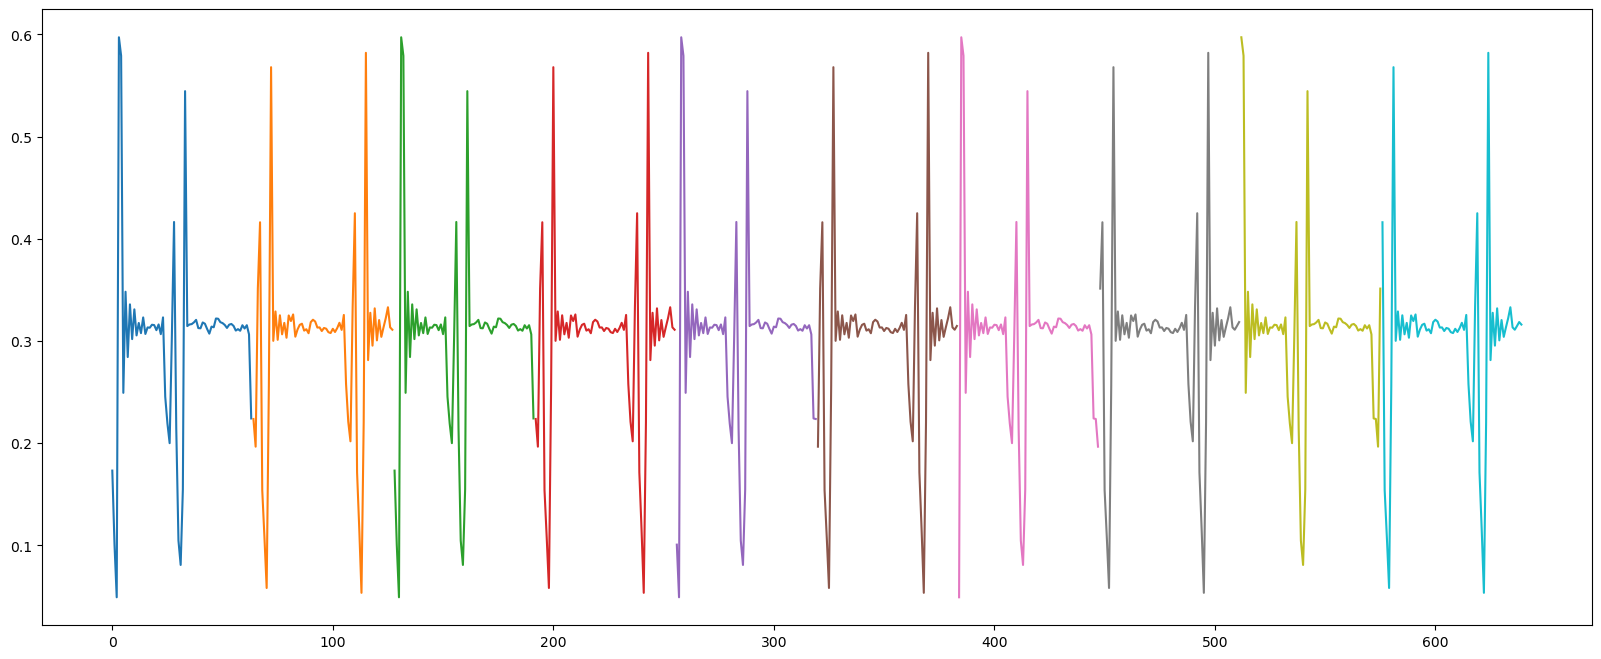

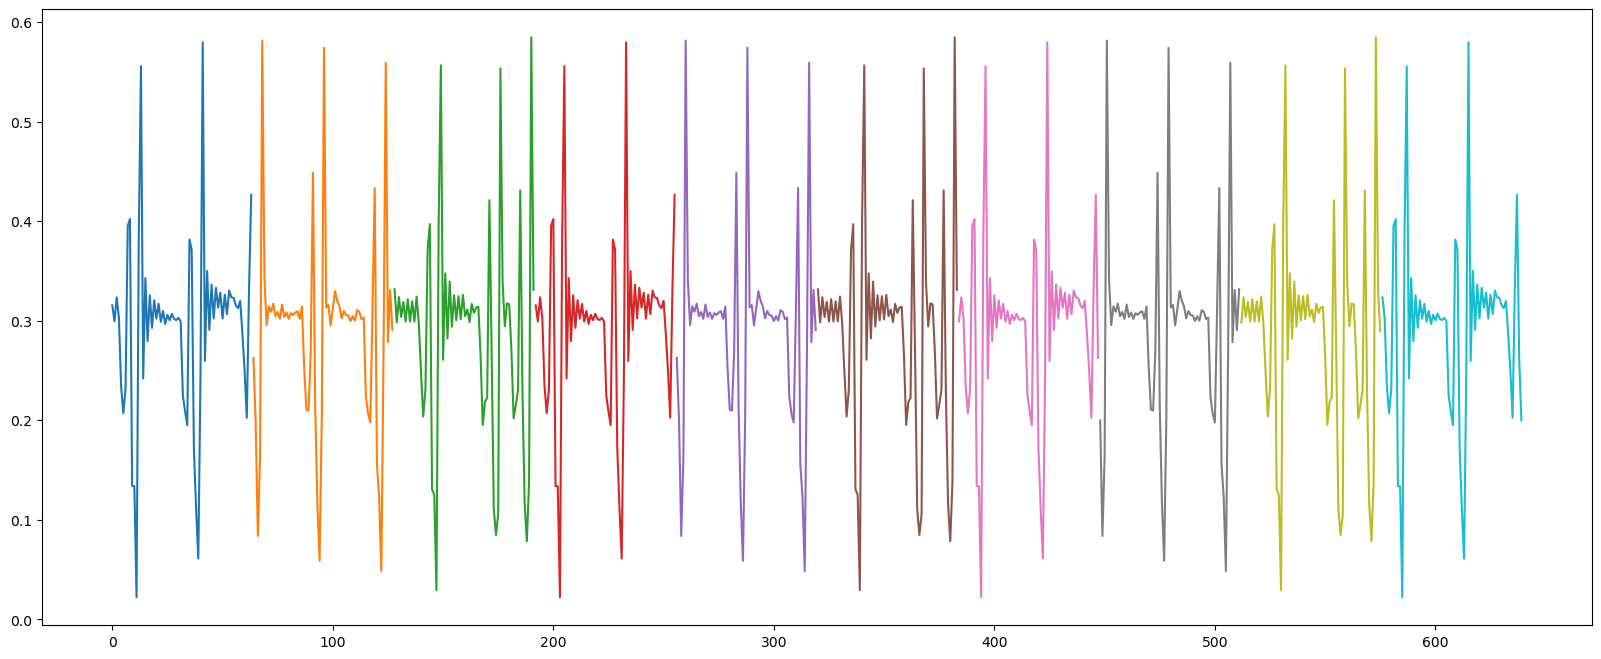

In [13]:
variable = 1

print("Variable:", name_list[ground_truth_variable[variable]])
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[0][window,:,variable])
plt.show()
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[1][window,:,variable])
plt.show()

for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[2][window,:,variable])
plt.show()
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[3][window,:,variable])
plt.show()

# Create Model 

In [14]:
batch_size = 64
model_dimension = 48
encoder_feed_forward = 128       
num_layers= 1
num_heads= 4        
encoder_dropout_rate =0.1
segment_sizes=16
segment_stride=4

transpose_cnn_kernal_size = segment_sizes


In [15]:
model = tm.EncoderTransformer(
    num_layers=num_layers,
    model_dimension=model_dimension,            
    num_heads=num_heads,
    encoder_feed_forward=encoder_feed_forward,           
    model_input_size =  input_window,      
    model_output_size = input_window,
    encoder_dropout_rate =encoder_dropout_rate ,
    segment_sizes=segment_sizes,
    segment_stride=segment_stride,
    transpose_cnn_for_rekonstruction=True,
    transpose_cnn_kernal_size=transpose_cnn_kernal_size,
    output_dim = y_train.shape[-1]
    
    )

#Learning rate schedule
steps_per_epoch = (len(x_train) // batch_size)
learning_rate = lrs.CosineDecayWithWarmup(steps_per_epoch*4,5e-4,steps_per_epoch*45)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98) 
model(x_train[:batch_size,:,:])
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer,
    metrics=tf.keras.losses.MeanSquaredError()
    )

model.summary()

stride 2
stride 2
Model: "encoder_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segmentation_projektion (Se  multiple                 13200     
 gmentationProjektion)                                           
                                                                 
 encoder_layer (EncoderLayer  multiple                 50144     
 )                                                               
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 feed_forward_with_sigmoid_a  (64, 16, 48)             12464     
 ctivation (Sequential)                                          
                                                                 
 conv1d_transpose (Conv1DTra  multiple                 2307      
 nspose)                     

# Train Model 

In [16]:
#Use early stopping to hit the optimum. 
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error',
    mode='min',
    #After finishing training take the best weights
    restore_best_weights = True,  
    #Stopp traning after x epochs without improvement. 
    patience = 10,       
)

model_history = model.fit(
            x= x_train,
            y= y_train,   
            #validation_split=0.20,     
            validation_data = (x_valid, y_valid),
            steps_per_epoch= (x_train.shape[0]) // batch_size,
            batch_size=batch_size,
            epochs=50,
            shuffle=True,                
            callbacks=[cb]
            )

Epoch 1/50
390/390 [==============================] - 4s 7ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 2/50
390/390 [==============================] - 2s 6ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/50
390/390 [==============================] - 3s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/50
390/390 [==============================] - 2s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/50
390/390 [========

# Evaluation


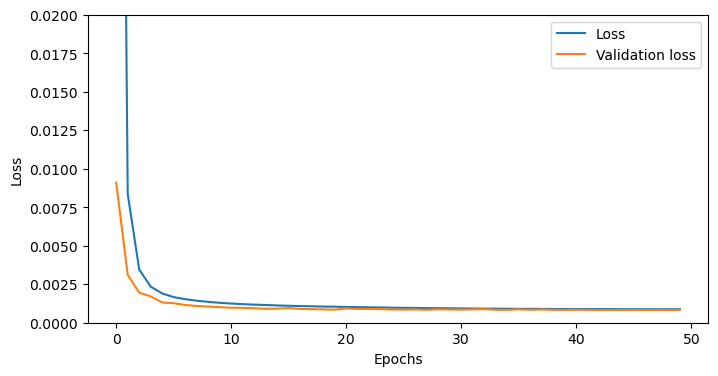

In [17]:
plt.rcParams['figure.figsize'] = [8, 4]

plt.plot(model_history.history['loss'], label='Loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0,0.02))
plt.legend()
plt.show()

## Reconstruction Error

In [18]:
for variable in range(len(test_data_preprocessed_x)):
    print(all_test_data_names[variable])
    model.evaluate(test_data_preprocessed_x[variable], test_data_preprocessed_y[variable])


Normal
34/34 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Drehtisch Widerstand
10/10 [==============================] - 0s 3ms/step - loss: 0.0199 - mean_squared_error: 0.0198
Drehtisch Blockiert
4/4 [==============================] - 0s 3ms/step - loss: 0.1457 - mean_squared_error: 0.1478
Drehtisch zu wenig widerstand
6/6 [==============================] - 0s 4ms/step - loss: 0.0109 - mean_squared_error: 0.0107
Transportband Widerstand
5/5 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_squared_error: 0.0112


# Reconstruction of normal test data

34/34 [==============================] - 0s 1ms/step
normal test Data
(1024, 3)
(960,)
Variable: Gesamtstrom


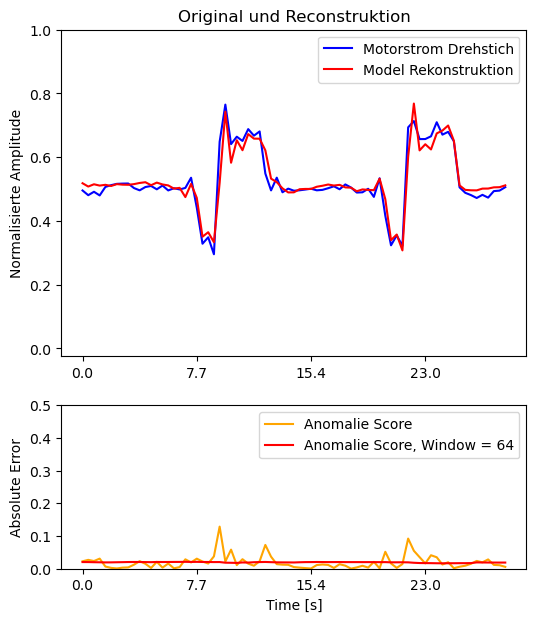

(960,)
Variable: Integerwert für den Motorstrom am Transportförderband


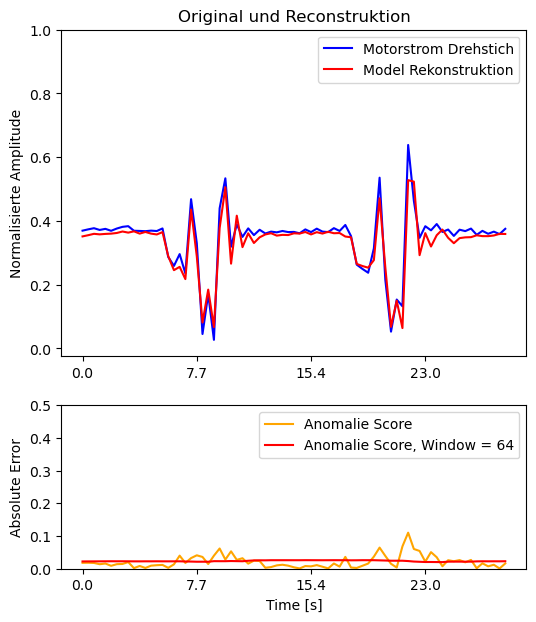

(960,)
Variable: Integerwert für den Motorstrom am Drehtisch


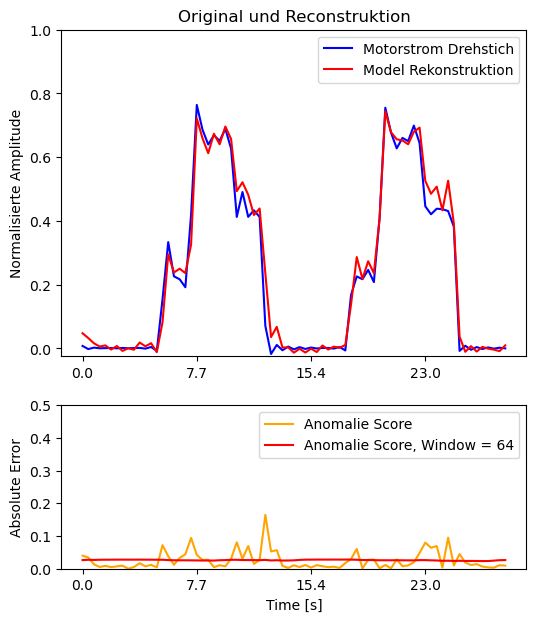

In [19]:
prediction_normal = model.predict(test_data_preprocessed_x[0])
y_normal = test_data_preprocessed_y[0]
prediction_reconstruct=pp.to_multiple_timeseries_reverse(prediction_normal, stride_of_window=1)
y_reconstruct=pp.to_multiple_timeseries_reverse(y_normal, stride_of_window=1)
plt.rcParams['figure.figsize'] = [6, 7]

range_l = 190
range_u = 265

print("normal test Data")

print(prediction_reconstruct.shape)
for variable in range(prediction_reconstruct.shape[-1]):

    mean=[]
    window=64
    for l in range(len(y_reconstruct)-window):
        mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,variable]-y_reconstruct[l:l+window,variable]))]

    mean = np.array(mean)
    print(mean.shape)


    fig, ax = plt.subplots(2, height_ratios=[2,1])
    print("Variable:", name_list[ground_truth_variable[variable]])
    ax[0].plot(y_reconstruct[range_l:range_u,variable], "b")
    ax[0].plot(prediction_reconstruct[range_l:range_u,variable], "r")
    ax[0].legend(["Motorstrom Drehstich", "Model Rekonstruktion"])#[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
    ax[0].set_ylabel("Normalisierte Amplitude")
    ax[0].title.set_text('Original und Reconstruktion')
    #fig.title("Drehstich ohne Anomalie")
    ax[0].set_ylim(-0.025, 1)
    time=np.arange(0,range_u-range_l,20)
    ax[0].set_xticks(time, np.round((time*384)/1000, 1))


    ax[1].plot(np.abs(y_reconstruct[range_l:range_u,variable]-prediction_reconstruct[range_l:range_u,variable]), "orange")
    ax[1].plot(mean[range_l:range_u], "r")
    
    ax[1].set_ylim(0, 0.5)
    ax[1].set_xticks(time, np.round((time*384)/1000, 1))

    ax[1].set_ylabel("Absolute Error")
    ax[1].set_xlabel("Time [s]")
    ax[1].legend(["Anomalie Score", "Anomalie Score, Window = 64"])
    
    plt.show()


## Reconstruction of anomalie test data for each Anomalie

Plot one window of all variable of all anomalie classes

10/10 [==============================] - 0s 3ms/step
(256, 3)
(256, 3)
Anomlie: Drehtisch Widerstand
Variable: Gesamtstrom
(192,)


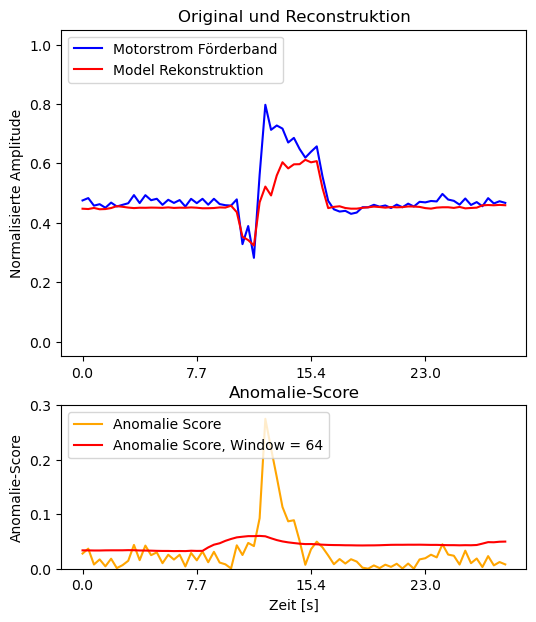

Variable: Integerwert für den Motorstrom am Transportförderband
(192,)


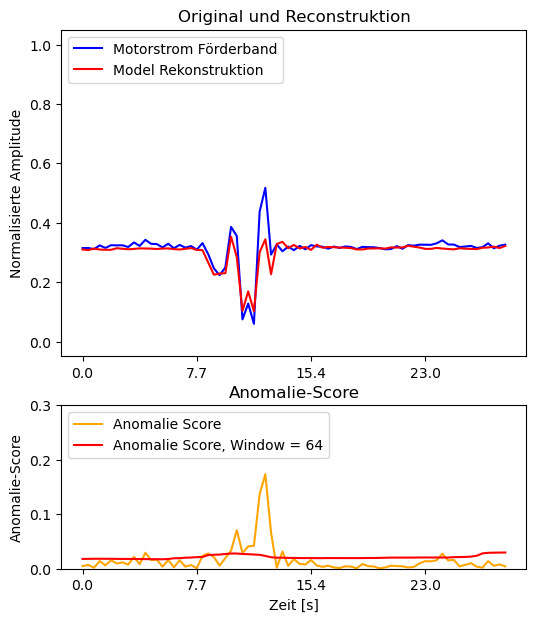

Variable: Integerwert für den Motorstrom am Drehtisch
(192,)


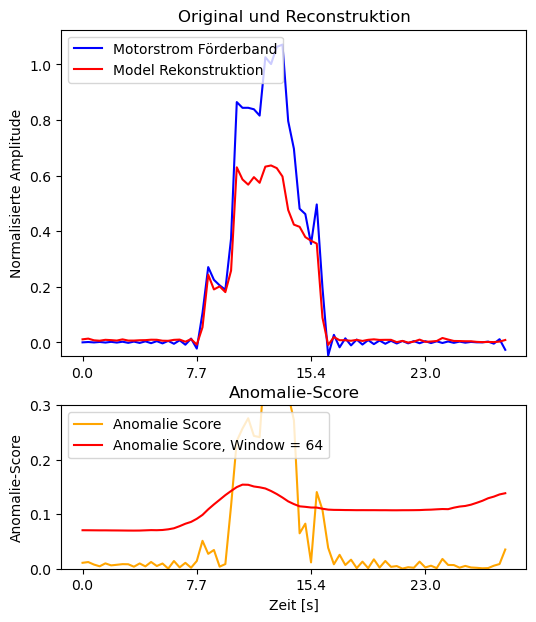

4/4 [==============================] - 0s 750us/step
(64, 3)
(64, 3)
Anomlie: Drehtisch Blockiert
Variable: Gesamtstrom
(0,)


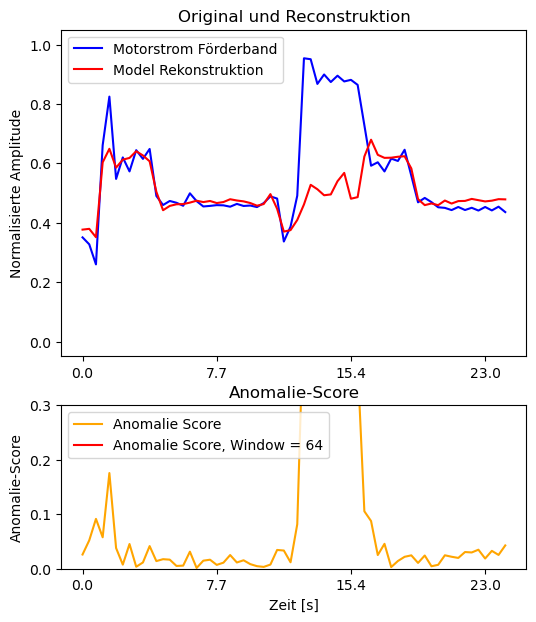

Variable: Integerwert für den Motorstrom am Transportförderband
(0,)


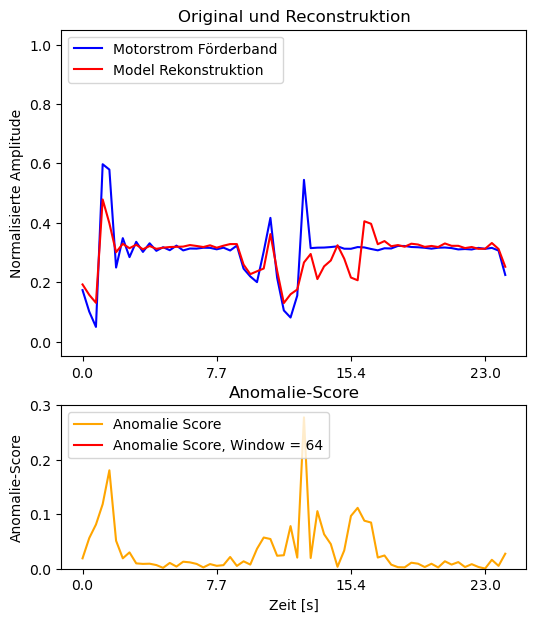

Variable: Integerwert für den Motorstrom am Drehtisch
(0,)


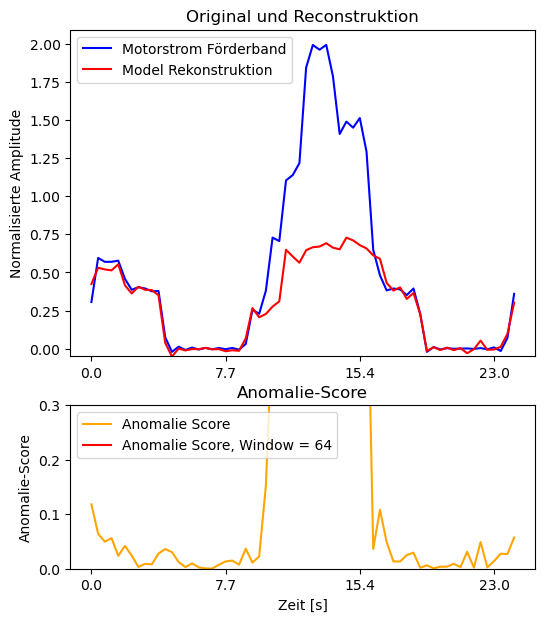

6/6 [==============================] - 0s 3ms/step
(128, 3)
(128, 3)
Anomlie: Drehtisch zu wenig widerstand
Variable: Gesamtstrom
(64,)


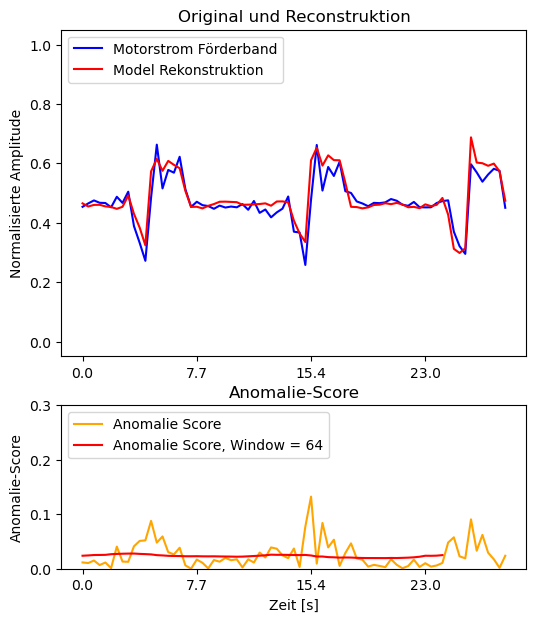

Variable: Integerwert für den Motorstrom am Transportförderband
(64,)


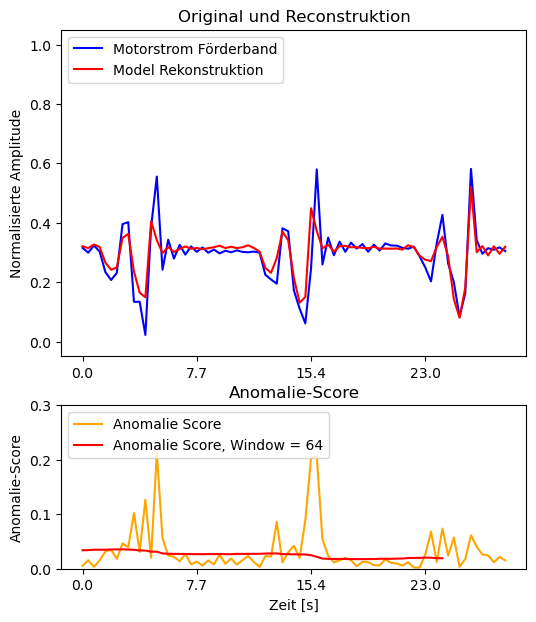

Variable: Integerwert für den Motorstrom am Drehtisch
(64,)


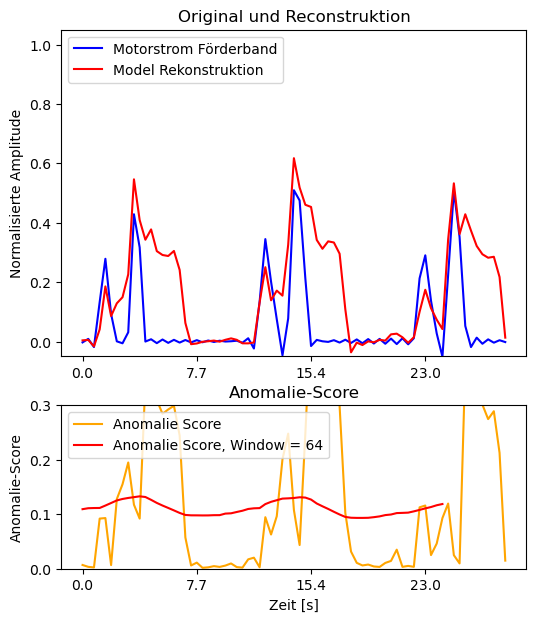

5/5 [==============================] - 0s 3ms/step
(128, 3)
(128, 3)
Anomlie: Transportband Widerstand
Variable: Gesamtstrom
(64,)


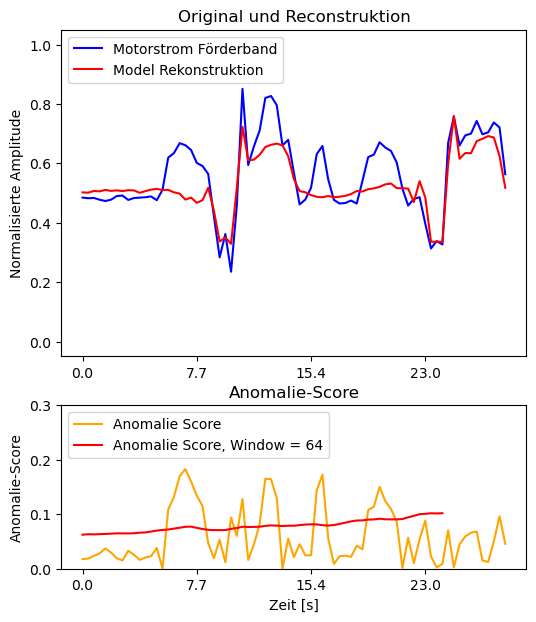

Variable: Integerwert für den Motorstrom am Transportförderband
(64,)


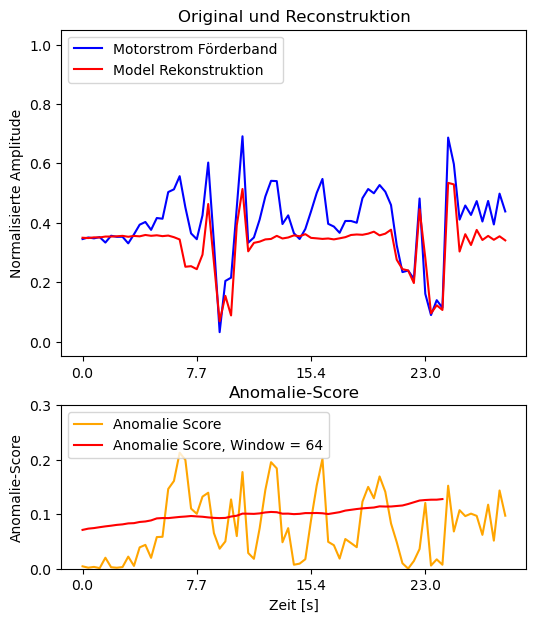

Variable: Integerwert für den Motorstrom am Drehtisch
(64,)


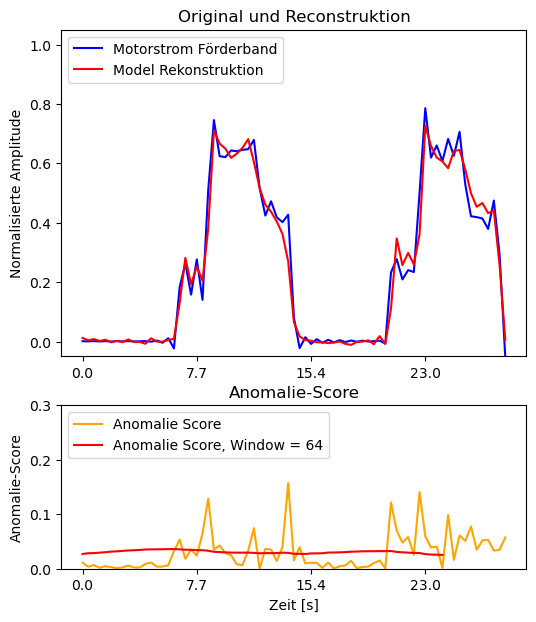

In [20]:
plt.rcParams['figure.figsize'] = [6, 7]
test_data_anaomlie_prediction=[]
test_data_anomalie_y=[]

range_l = 0#170#250#0#0#250
range_u = 75#245#480#150#150#480

for variable in range(1,len(test_data_preprocessed_x)):
    
    test_data_anaomlie_prediction += [model.predict(test_data_preprocessed_x[variable])]
    test_data_anomalie_y += [test_data_preprocessed_y[variable]]

    prediction_reconstruct=pp.to_multiple_timeseries_reverse(test_data_anaomlie_prediction[variable-1], stride_of_window=1)
    y_reconstruct=pp.to_multiple_timeseries_reverse(test_data_anomalie_y[variable-1], stride_of_window=1)
    print(y_reconstruct.shape)

    mean=[]
    
   

    print(prediction_reconstruct.shape)
    print("Anomlie:", all_test_data_names[variable])
    for j in range(prediction_reconstruct.shape[-1]):
        print("Variable:", name_list[ground_truth_variable[j]])


        mean=[]
        window=64
        for l in range(len(y_reconstruct)-window):
            mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,j]-y_reconstruct[l:l+window,j]))]

        mean = np.array(mean)
        print(mean.shape)


        fig, ax = plt.subplots(2, height_ratios=[2,1])
   
        ax[0].set_ylim([-0.05, np.max(np.append(1, np.max(y_reconstruct[range_l:range_u,j]))*1.05 )])
        ax[0].plot(y_reconstruct[range_l:range_u,j], "b")
        ax[0].plot(prediction_reconstruct[range_l:range_u,j], "r")
        ax[0].set_xticks(time, np.round((time*384)/1000, 1))
        ax[0].title.set_text('Original und Reconstruktion')
        ax[0].legend(["Motorstrom Förderband", "Model Rekonstruktion"], loc="upper left")#[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
        time=np.arange(0,range_u-range_l,20)
        plt.xlabel("Zeit [s]")
        ax[0].set_ylabel("Normalisierte Amplitude")       





        ax[1].plot(np.abs(y_reconstruct[range_l:range_u,j]-prediction_reconstruct[range_l:range_u,j]), "orange")
        ax[1].plot(mean[range_l:range_u], "r")
        ax[1].title.set_text('Anomalie-Score')
        ax[1].set_ylabel("Anomalie-Score")     
        ax[1].legend(["Anomalie Score", "Anomalie Score, Window = 64"], loc="upper left")
        ax[1].set_ylim(0,0.3)

        time=np.arange(0,range_u-range_l,20)
        plt.xticks(time, np.round((time*384)/1000, 1))
        plt.show()
    

In [21]:
#Input dim: (sample, timeseries window) or (sample, timeseries window, variable) 
def calculate_mse(prediction, y, add_mse_fromEach_variable=False): 
    mse=[]
    print(prediction.shape, y.shape)

    if len(prediction.shape)==2:
        mse=[]
        for i in range(len(prediction)):
            mse += [np.mean( np.square(prediction[i]-y[i]))]
    elif len(prediction.shape)==3:
        for sample in range(prediction.shape[0]):
            tmp=[]
            for variable in range(y.shape[-1]):
                tmp += [np.mean( np.square(prediction[sample,:,variable]-y[sample,:,variable]))]
            mse += [tmp]
        if add_mse_fromEach_variable:
            added_mse=[]
            for i in range(len(mse)):
                added_mse += [np.mean(mse[i])]
            
            mse=added_mse

    else:
        raise Exception("Dimension error")

    return np.array(mse)

In [22]:
mse_normal = calculate_mse(prediction_normal, test_data_preprocessed_y[0])

(1061, 64, 3) (1061, 64, 3)


In [23]:
mse_anomlie=[]
for variable in range(len(test_data_anaomlie_prediction)):
    mse_anomlie += [calculate_mse(test_data_anaomlie_prediction[variable], test_data_anomalie_y[variable])]


(316, 64, 3) (316, 64, 3)
(112, 64, 3) (112, 64, 3)
(163, 64, 3) (163, 64, 3)
(135, 64, 3) (135, 64, 3)


# Precision-Recall and Histogram of Anomalie-Score

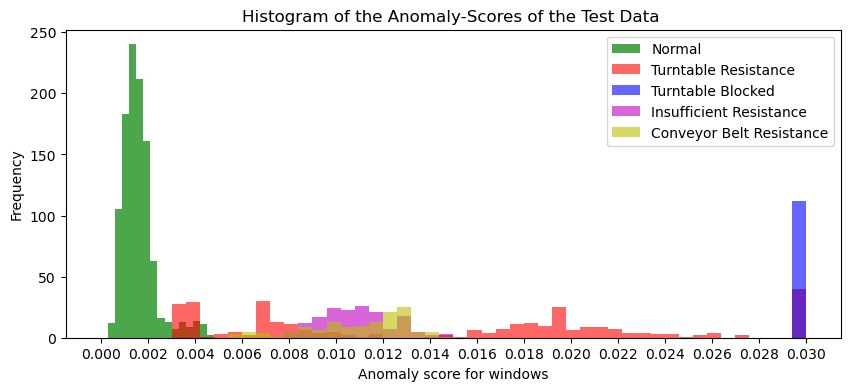

AUCPR: 0.9960916662288322


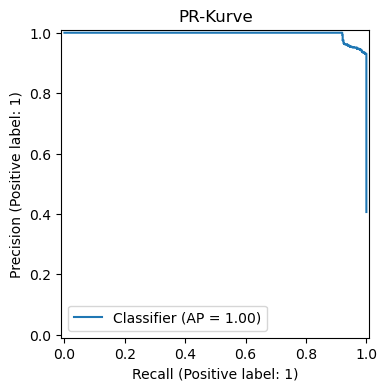

In [24]:
plot_range=[0.00, 0.03]
plt.rcParams['figure.figsize'] = [10, 4]
density=False
colors=["r","b", "m", "y", "c", "black"]

plt.hist(np.mean(mse_normal[:,:],axis=-1),bins = 100,density= density, range=plot_range,color="g",alpha=0.7,log=False, )

for j in range(len(mse_anomlie)):
     mse_mean_over_variablen=np.mean(mse_anomlie[j][:,:],axis=-1)

     for variable in range(len(mse_mean_over_variablen)):
          if mse_mean_over_variablen[variable] > plot_range[-1]:
               mse_mean_over_variablen[variable] = plot_range[-1]

     plt.hist(mse_mean_over_variablen,bins = 50,density= density, range=plot_range,alpha=0.6,log=False, color=colors[j])



plt.legend( ['Normal', 'Turntable Resistance', 'Turntable Blocked', 'Insufficient Resistance', 'Conveyor Belt Resistance'])
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Frequency")
plt.xlabel("Anomaly score for windows")
plt.title("Histogram of the Anomaly-Scores of the Test Data ")
plt.show()
mse_normal_mean=np.mean(mse_normal[:,:], axis=-1)

mse_anomal_sum=np.array(np.mean(mse_anomlie[0][:,:], axis=-1))
for j in range(1,len(mse_anomlie)):
     mse_anomal_sum=np.append(mse_anomal_sum, np.mean(mse_anomlie[j][:,:], axis=-1), axis=-1)

label_n = np.zeros(len(mse_normal_mean))
label_a = np.ones(len(mse_anomal_sum))
y_score=np.append(mse_normal_mean,mse_anomal_sum)
y_test=np.append(label_n,label_a)


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_score)
auc_precision_recall = sklearn.metrics.auc(recall, precision)
print("AUCPR:",auc_precision_recall)
sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_score)
#plt.xlabel("Precsision TP/(TP+FP)")
#plt.ylabel("Recall TP/(TP+FN)")    
plt.title("PR-Kurve")
plt.show()


In [25]:
normal_score = np.mean(mse_normal[:,:],axis=-1)
anormal_score =  np.append(np.append(np.mean(mse_anomlie[0][:,:],axis=-1),np.mean(mse_anomlie[1][:,:])) , np.mean(mse_anomlie[2][:,:]) )

scores = np.append( normal_score, anormal_score)
label = np.append( np.zeros(len(normal_score)) ,np.ones(len(anormal_score)) )


In [26]:
mean_score=scores
thresholds_for_f1=np.arange(0,0.1,0.0001)
anomalie_pred_fro_each_threshold=[]
anomalie_pred_fro_each_threshold= [[0 if (mse<threshold) else 1 for mse in mean_score] for threshold in thresholds_for_f1]

f1_scores=[]
for anomalies_for_each_treshold in anomalie_pred_fro_each_threshold: 
    f1_scores+=[sklearn.metrics.f1_score(label, anomalies_for_each_treshold)]


    #print("\n")

print("threshold",thresholds_for_f1[np.argmax(f1_scores)])
print("best f1", max(f1_scores))

threshold 0.003
best f1 0.9190751445086706


In [28]:
list_of_thresholds = []

for i in range(np.array(mse_normal).shape[-1]):

    list_of_thresholds+=[np.max(mse_normal[:,i])]


# Define thresholds for each variable

In [29]:
np.float64(list_of_thresholds)

array([0.00401608, 0.0069619 , 0.00455872])

In [30]:
list_of_thresholds[0] = list_of_thresholds[0] * 1.2
list_of_thresholds[1] = list_of_thresholds[1] * 1.5
list_of_thresholds[2] = list_of_thresholds[2] * 1.5

In [31]:
np.float64(list_of_thresholds)

array([0.0048193 , 0.01044286, 0.00683807])

In [32]:
import json

if True:

    model.save("Model")
    
    data=0
    file = open("config.json", "r")
    data = json.load(file)
    file.close()

    new_data={
        "thresholds": dict(zip(range(len(list_of_thresholds)), np.float64(list_of_thresholds) )) ,
        "ground_truth_name_list": dict(zip(range(len(ground_truth_name_list)), ground_truth_name_list)),
        "sliding_window_stride_deployment": 8
    }    
    
    data.update(new_data)

    with open("config.json", "w") as file:  
        json.dump(data, file, indent=2)
        file.close()       


INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets
